D:\software\Anaconda\envs\geomapping\lib\site-packages\cartopy\mpl\geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


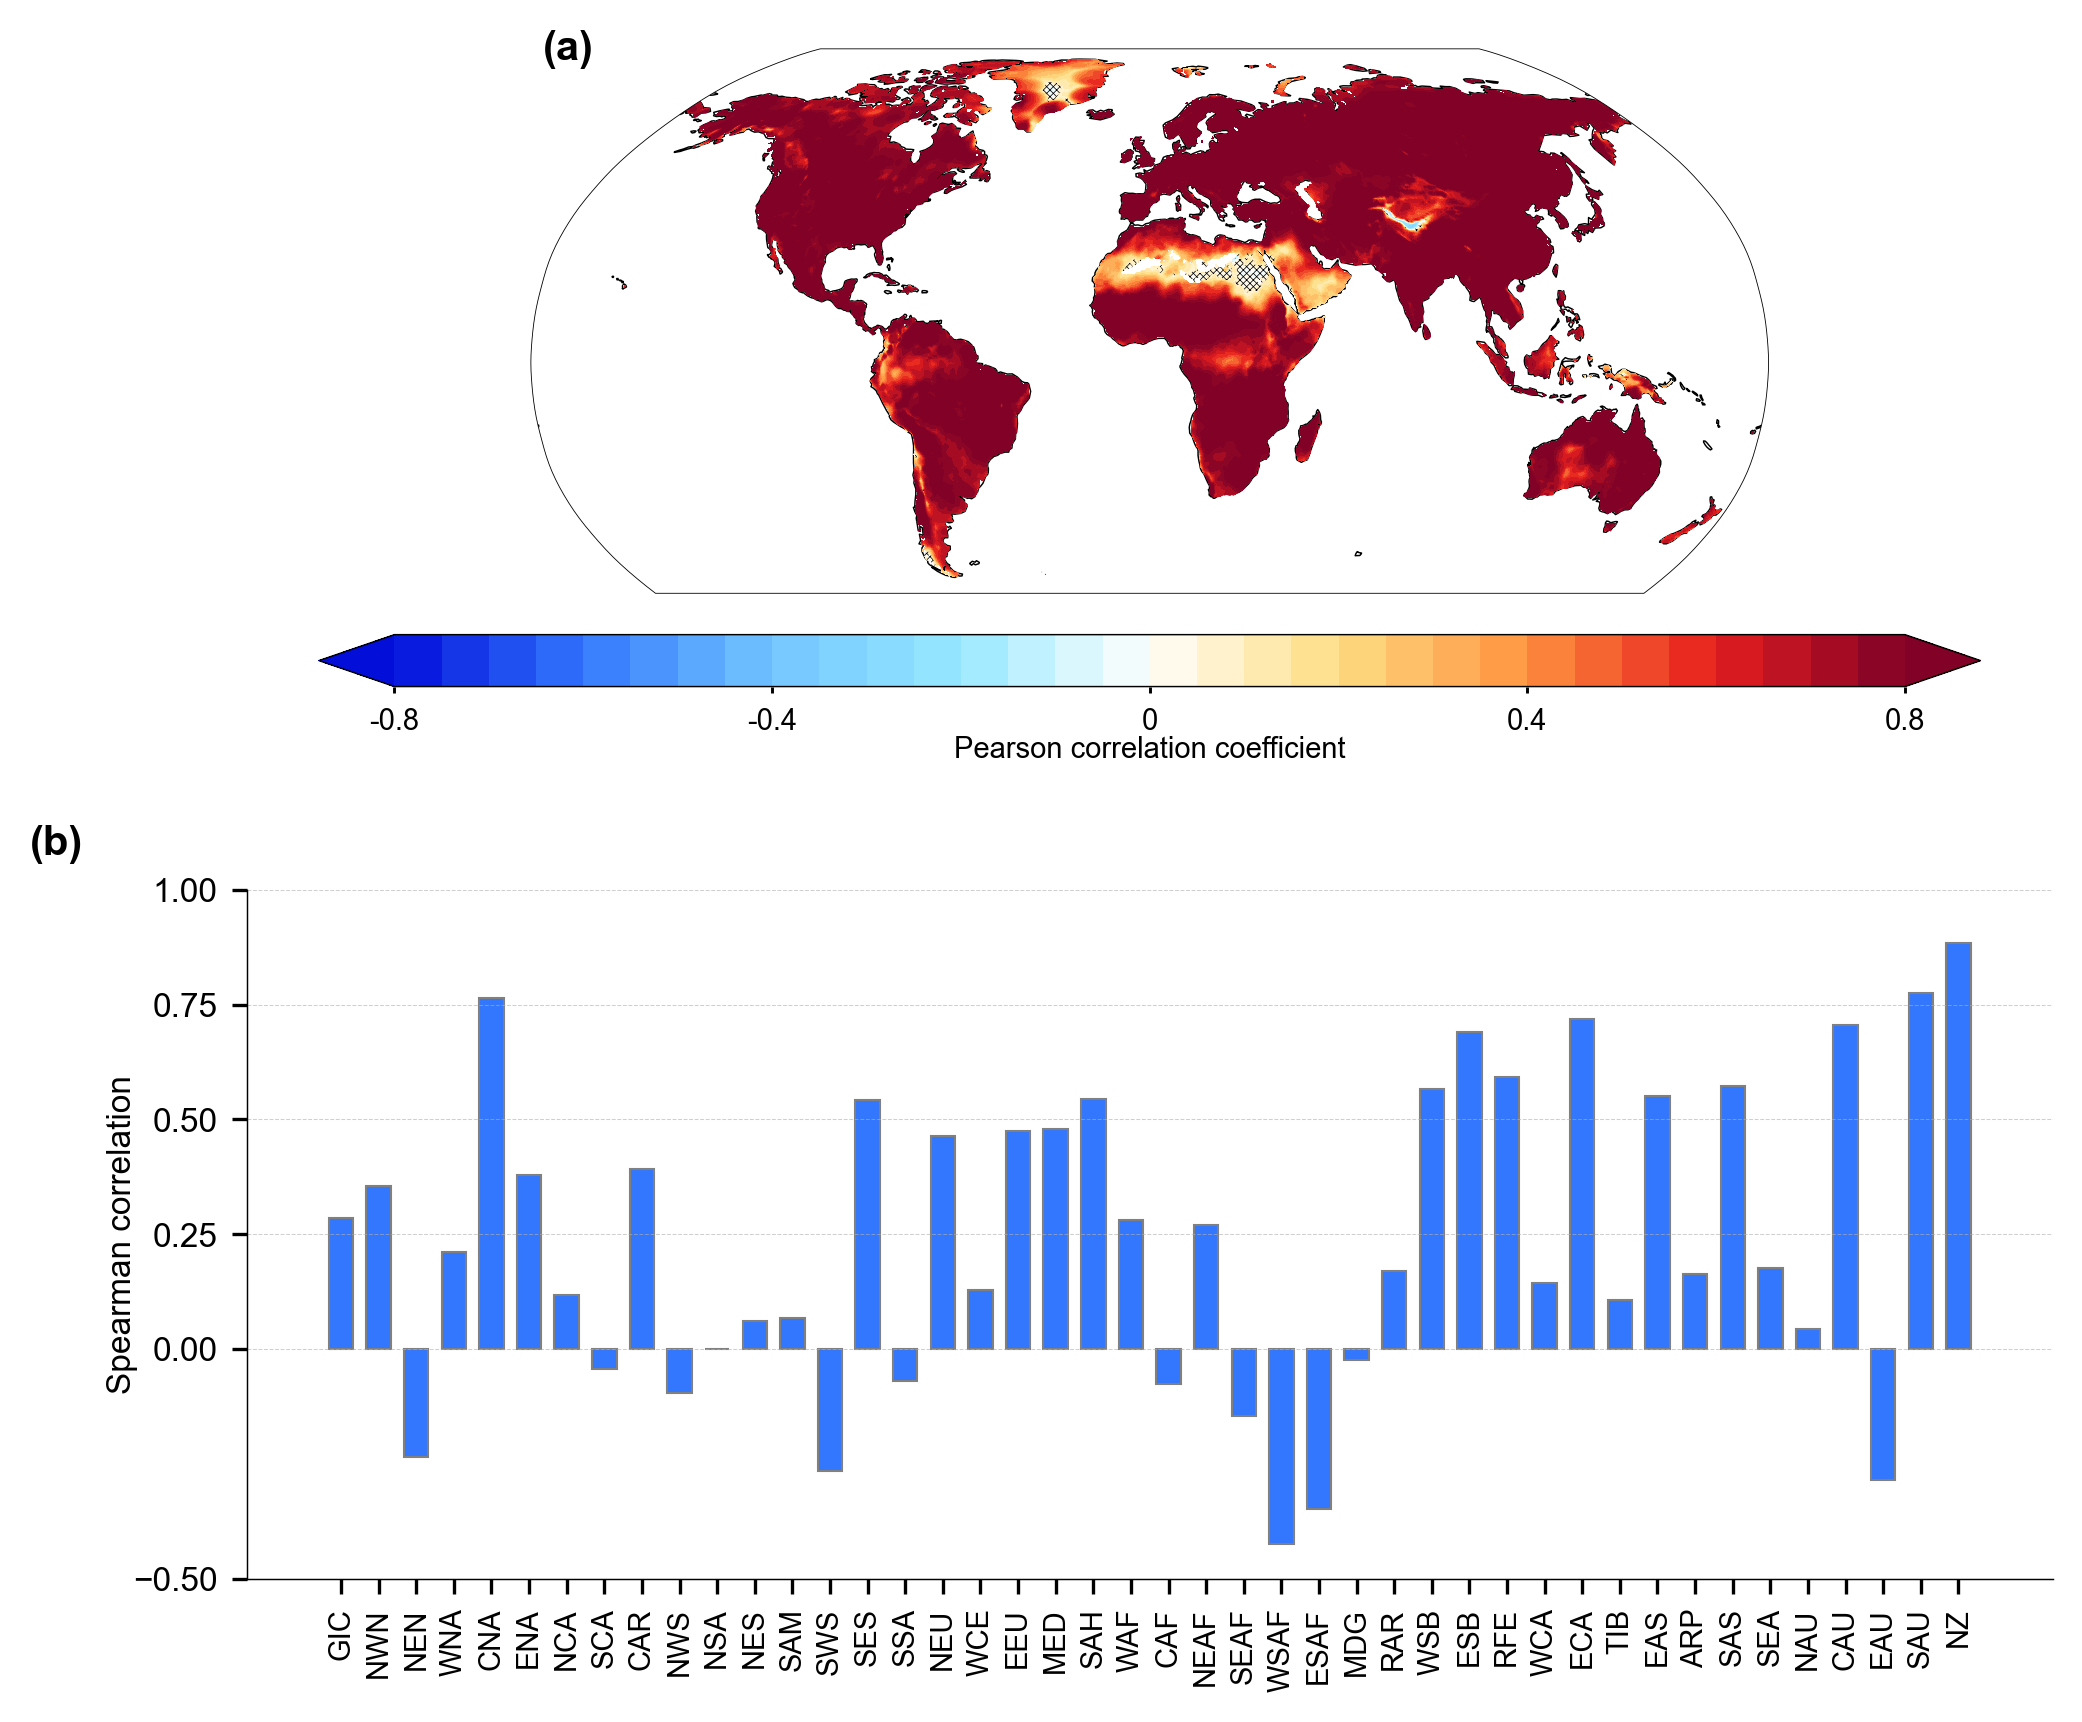

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import matplotlib as mpl
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
import pandas as pd

# 色带
clist2 = ["#030ED9","#3377FE","#72C4FF","#96E8FF","#FFFFFC","#FEDF84","#FE9440", "#E61E1E", "#820227"]
anomaly_cmap = LinearSegmentedColormap.from_list('anomaly', clist2)

# hatch线宽更细
mpl.rcParams['hatch.linewidth'] = 0.18

def get_geotiff_data(path):
    ds = gdal.Open(path)
    gt = ds.GetGeoTransform()
    array = ds.ReadAsArray()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    xres, yres = gt[1], gt[5]
    xcor, ycor = gt[0], gt[3]
    lat = np.arange(ycor + 0.5 * yres, ycor + 0.5 * yres + yres * ysize, yres)
    lon = np.arange(xcor + 0.5 * xres, xcor + 0.5 * xres + xres * xsize, xres)
    return lon, lat, array

# 读取数据
pearson_tif = r"J:\CMIP6_eco\pr_validation\CRU-TS\Pearson_corr_monthly\pearson_r.tif"
pearson_p_tif = r"J:\CMIP6_eco\pr_validation\CRU-TS\Pearson_corr_monthly\pearson_p.tif"
lon, lat, pearson_arr = get_geotiff_data(pearson_tif)
_, _, p_arr = get_geotiff_data(pearson_p_tif)

# 柱状图数据
spearman_xlsx = r"J:\CMIP6_eco\pr_validation\CRU-TS\PRCPTOT\prcptot_trend_spatialcorr.xlsx"
spearman_df = pd.read_excel(spearman_xlsx, index_col=0).T
spearman_df = spearman_df.dropna().astype(float)

plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams.update({"font.size": 8})

fig = plt.figure(figsize=(7, 6), dpi=300)
projection = ccrs.Robinson()
vmin, vmax = -0.8, 0.8
levels = np.arange(-0.8, 0.8001, 0.05)
main_ticks = [-0.8, -0.4, 0, 0.4, 0.8]

# ---- 图a: 空间相关 ----
ax_a = fig.add_subplot(2, 1, 1, projection=projection)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cs = ax_a.contourf(
    lon, lat, pearson_arr, 
    transform=ccrs.PlateCarree(), 
    cmap=anomaly_cmap, levels=levels, norm=norm, extend="both", zorder=2
)
ax_a.coastlines(linewidth=0.35)
for spine in ax_a.spines.values():
    spine.set_linewidth(0.2)
ax_a.set_extent([-179.9999, 179.9999, -60, 90], ccrs.PlateCarree())
ax_a.text(0.01, 0.98, "(a)", fontsize=10, fontweight="bold", transform=ax_a.transAxes)

# 用更细的“×”hatch，置于最顶层
sig_mask = (p_arr >= 0.05) & (~np.isnan(p_arr))
hatch_arr = np.zeros_like(pearson_arr)
hatch_arr[sig_mask] = 1
ax_a.contourf(
    lon, lat, hatch_arr, levels=[-0.1, 0.5, 1.1], 
    hatches=[None, 'xxxxxxxxxxxxxxx'],
    colors="none", transform=ccrs.PlateCarree(), add_colorbar=False, zorder=100000
)

# colorbar
cbar_a = fig.colorbar(
    cs, ax=ax_a, orientation='horizontal', pad=0.06, aspect=32, shrink=0.92,
    ticks=main_ticks
)
cbar_a.ax.tick_params(size=1.5, width=0.7, labelsize=7, direction="out", which="major", bottom=True)
cbar_a.set_ticks(main_ticks)
cbar_a.set_ticklabels(main_ticks)
cbar_a.ax.xaxis.set_minor_locator(mpl.ticker.NullLocator())
cbar_a.outline.set_linewidth(0.35)
cbar_a.ax.set_xlabel("Pearson correlation coefficient", fontsize=7, labelpad=0)
cbar_a.ax.xaxis.set_label_position('bottom')

# ---- 图b: 区域spearman柱状图 ----
ax_b = fig.add_subplot(2, 1, 2)
regions = spearman_df.index
bars = spearman_df["Spearman_corr"].values
ax_b.bar(regions, bars, color="#3377FE", width=0.65, edgecolor="gray", linewidth=0.5)
ax_b.set_ylim(-0.5, 1.0)
ax_b.set_ylabel("Spearman correlation", fontsize=8)
ax_b.set_xticks(np.arange(len(regions)))
ax_b.set_xticklabels(regions, fontsize=7, rotation=90, ha="center")  # 关键改回center
ax_b.set_yticks([-0.5, 0, 0.25, 0.5, 0.75, 1.0])
ax_b.text(-0.12, 1.05, "(b)", fontsize=10, fontweight="bold", transform=ax_b.transAxes)
for spine in ["top", "right"]:
    ax_b.spines[spine].set_visible(False)
ax_b.spines["left"].set_linewidth(0.35)
ax_b.spines["bottom"].set_linewidth(0.35)
ax_b.grid(axis="y", linestyle="--", linewidth=0.25, alpha=0.6)
ax_b.yaxis.set_label_coords(-0.06, 0.5)  # 让y轴标签与刻度对齐

fig.subplots_adjust(left=0.12, right=0.98, top=0.97, bottom=0.12, hspace=0.22)
plt.savefig(r"E:\phd_l1\Understanding record-shattering compound drought-heatwave dynamics and their severe ecosystem impacts\EF\Major Revision\Revised_figs\obs_pr_validation.jpg", dpi=300, bbox_inches="tight")
plt.show()
